In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson3D
problem = Poisson3D()

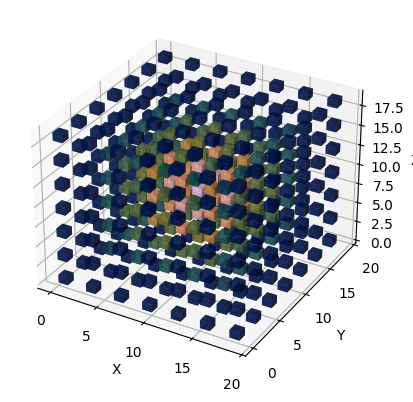

In [3]:
X, Y, Z, u_solution = problem.exact_solution(nx=7, ny=7, nz=7)

def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = u_solution.shape[0]
y_num = u_solution.shape[1]
z_num = u_solution.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(u_solution)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [4]:
X, Y, Z, u_solution = problem.exact_solution(nx=32, ny=32, nz=32)

# Optimiser

In [5]:
class HungryLMQR:
    """
    The final Levenberg-Marquardt optimiser.
    
    This version combines:
    1. The memory-efficient QR-SVD approach.
    2. The "hungry" logic for taking aggressive steps when progress stalls.
    """
    def __init__(
        self,
        # Standard LM parameters
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        max_trials: int = 20,
        # Hungriness parameters
        aggressive_factor: float = 0.75,
        steps_before_aggressive: int = 10,
        required_gain_before_aggressive: float = 0.9,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials
        self.aggressive_factor = aggressive_factor
        self.steps_before_aggressive = steps_before_aggressive
        self.required_gain_before_aggressive = required_gain_before_aggressive

    def init(self, params: eqx.Module):
        """Initializes the optimizer state."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.steps_before_aggressive,), jnp.inf),
        }

    def update(self, R, Q_T_r, current_loss, params, state, evaluate_loss_fn):
        current_lambda = state['lambda']
        loss_history = state['loss_history']
        _, unflatten = jax.flatten_util.ravel_pytree(params)

        # --- Hungriness Logic: Track progress ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)
        not_enough_progress = current_loss > self.required_gain_before_aggressive * reference_loss

        # --- SVD Calculation (same as before) ---
        U_R, S, Vt = jnp.linalg.svd(R, full_matrices=False)
        g_prime = U_R.T @ Q_T_r

        # --- Define the two branches: Aggressive or Regular ---

        def _aggressive_step(c_lambda):
            """Branch 1: Progress has stalled. Take a forced, aggressive step."""
            # Calculate a more aggressive lambda
            trial_lambda = c_lambda / self.decrease_factor * self.aggressive_factor
            
            delta_prime = -S * g_prime / (S**2 + trial_lambda)
            delta_flat = Vt.T @ delta_prime
            
            # We "accept" this forced step and report its lambda.
            return True, trial_lambda, delta_flat, 1

        def _regular_lm_search(c_lambda):
            """Branch 2: Progress is good. Perform a standard LM search."""
            def evaluate_trial_step(loop_val):
                _, trial_lambda, _, trial_count = loop_val
                delta_prime = -S * g_prime / (S**2 + trial_lambda)
                delta_flat = Vt.T @ delta_prime
                
                trial_params = eqx.apply_updates(params, unflatten(delta_flat))
                trial_loss = evaluate_loss_fn(trial_params)
                accepted = trial_loss < current_loss
                
                new_lambda = jax.lax.cond(accepted,
                                          lambda: trial_lambda, # On success, don't decrease yet
                                          lambda: trial_lambda * self.increase_factor)
                return accepted, new_lambda, delta_flat, trial_count + 1

            def continue_search(loop_val):
                accepted, _, _, trial_count = loop_val
                return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

            initial_loop_val = (False, c_lambda, jnp.zeros_like(Q_T_r), 0)
            return jax.lax.while_loop(continue_search, evaluate_trial_step, initial_loop_val)

        step_was_accepted, final_lambda, lm_delta, trial_count = jax.lax.cond(
            not_enough_progress,
            _aggressive_step,
            _regular_lm_search,
            operand=current_lambda
        )

        updates = unflatten(lm_delta)
        
        # --- Update the state, resetting history if we were aggressive ---
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': jax.lax.cond(
                not_enough_progress,
                lambda: jnp.full((self.steps_before_aggressive,), jnp.inf),
                lambda: new_loss_history
            )
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(lm_delta),
            'lambda': final_lambda,
        }
        
        return updates, new_state, metrics

# ====================================================================
# BATCHED TRAIN STEP using Incremental QR
# ====================================================================

@partial(jax.jit, static_argnums=(2, 3, 5))
def train_step(params, static_parts, optimiser, problem, collocation_points, mini_batch_size):
    num_params = jax.flatten_util.ravel_pytree(params)[0].size

    # Phase 1: Accumulate R and Qᵀr via incremental QR decomposition
    def qr_step(carry, batch_indices):
        R_accum, Q_T_r_accum = carry
        batch_coords = collocation_points[batch_indices]

        def residual_fn_mini_batch(p):
            model = eqx.combine(p, static_parts)
            residuals = problem.physics_residual(problem.residual_fn, model, batch_coords)
            return residuals, residuals

        J_mini_pytree, r_mini = jax.jacfwd(residual_fn_mini_batch, has_aux=True)(params)

        # --- CORRECTED JACOBIAN FLATTENING ---
        # `ravel_pytree` was incorrect. This new logic correctly forms the 2D matrix.
        J_mini_leaves = jax.tree_util.tree_leaves(J_mini_pytree)
        # Reshape each leaf and concatenate horizontally to get shape (batch_size, n_params)
        J_flat_mini = jnp.concatenate(
            [leaf.reshape(batch_coords.shape[0], -1) for leaf in J_mini_leaves],
            axis=1
        )

        # Form a combined matrix from the previous R and the new mini-batch Jacobian
        combined_matrix = jnp.vstack([R_accum, J_flat_mini])
        combined_residuals = jnp.concatenate([Q_T_r_accum, r_mini])
        
        # Perform QR on this slightly larger, but still tall-and-skinny matrix
        Q_new, R_new = jnp.linalg.qr(combined_matrix)
        
        # Update R to be the new R, which is still (n_params, n_params)
        R_final = R_new[:num_params, :]
        
        # Update Qᵀr by applying the new Qᵀ to the combined residuals
        Q_T_r_final = (Q_new.T @ combined_residuals)[:num_params]
        
        return (R_final, Q_T_r_final), None

    # Set up and run the scan over all mini-batches
    num_examples = collocation_points.shape[0]
    steps_per_epoch = (num_examples + mini_batch_size - 1) // mini_batch_size
    padded_size = steps_per_epoch * mini_batch_size
    all_indices = jnp.arange(padded_size) % num_examples
    batch_indices = all_indices.reshape((steps_per_epoch, mini_batch_size))
    
    initial_carry = (jnp.zeros((num_params, num_params)), jnp.zeros(num_params))
    
    (R_final, Q_T_r_final), _ = jax.lax.scan(
        qr_step, initial_carry, batch_indices
    )
    
    # Calculate current loss on the full dataset
    def full_loss_evaluator(p):
        model = eqx.combine(p, static_parts)
        full_residuals = problem.physics_residual(problem.residual_fn, model, collocation_points)
        return jnp.mean(full_residuals**2)
    
    current_loss = full_loss_evaluator(params)

    # Call the optimizer with the final R and Qᵀr
    updates, new_opt_state, metrics = optimiser.update(
        R_final, Q_T_r_final, current_loss, params, opt_state, full_loss_evaluator
    )
    
    new_params = eqx.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

In [6]:

key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**11
layer_sizes = [3, 16, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

print(collocation_points.shape)

optimiser = HungryLMQR(
    init_lambda=1e4,
    decrease_factor=0.9,
    increase_factor=1.01,
    aggressive_factor=0.8,
    steps_before_aggressive=20,
    max_trials=200,
    required_gain_before_aggressive=0.75,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

for epoch in range(2):
    params, opt_state, metrics = train_step(
        params, static, optimiser, problem, collocation_points, 2**11
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1:3d}, Loss: {metrics['loss']:.3e}, Lambda: {metrics['lambda']:.2e}, Elapsed time: {elapsed_seconds:.1f}s")


(2048, 3)


In [7]:
model = eqx.combine(params, static)

u_pred = model.predict(X, Y, Z)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 9.353e-01


In [8]:
error2 = error[::5, ::5, ::5]
print(error2.shape)

(7, 7, 7)


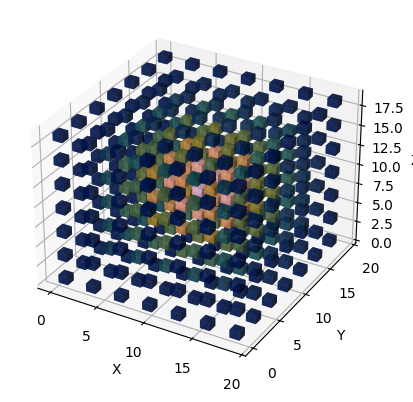

In [9]:
def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = error2.shape[0]
y_num = error2.shape[1]
z_num = error2.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(error2)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

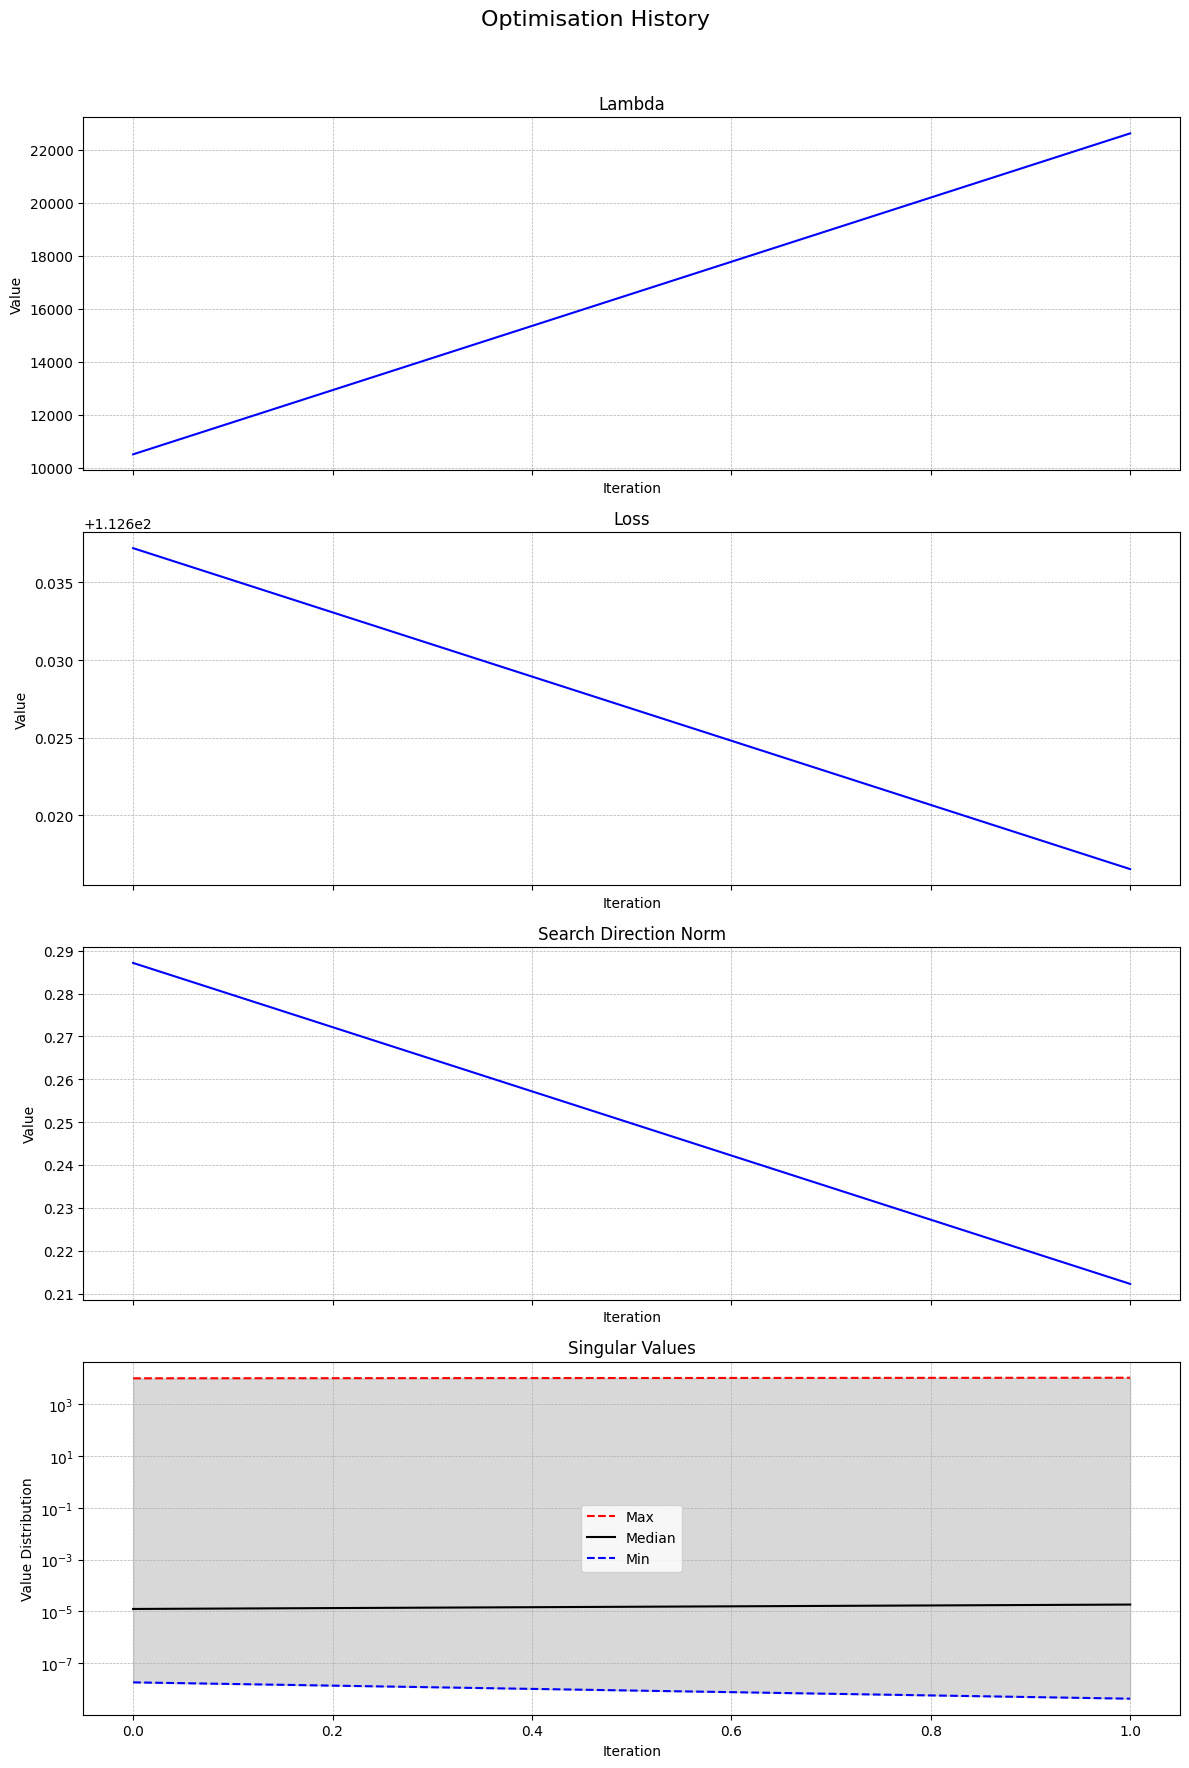

In [10]:
history.plot()